<a href="https://colab.research.google.com/github/Raineriojr/mvp4/blob/main/Treinamento_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prática de Machine Learning em Python
### Usando Dataset de Heart Failure Prediction

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Carga do Dataset

In [ ]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/Raineriojr/mvp4/main/heart.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

#codificação de variáveis e classes
dataset['Sex'] = dataset['Sex'].map({'F': 0, 'M': 1});
dataset['ExerciseAngina'] = dataset['ExerciseAngina'].map({'N': 0, 'Y': 1});
dataset = pd.get_dummies(dataset, columns=['ST_Slope'], prefix='ST_Slope');
dataset = pd.get_dummies(dataset, columns=['ChestPainType'], prefix='ChestPain');
dataset = pd.get_dummies(dataset, columns=['RestingECG'], prefix='Resting');

# Mostra as primeiras linhas do dataset
dataset.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPain_ASY,ChestPain_ATA,ChestPain_NAP,ChestPain_TA,Resting_LVH,Resting_Normal,Resting_ST
0,40,1,140,289,0,172,0,0.0,0,0,0,1,0,1,0,0,0,1,0
1,49,0,160,180,0,156,0,1.0,1,0,1,0,0,0,1,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,0,0,1,0,1,0,0,0,0,1
3,48,0,138,214,0,108,1,1.5,1,0,1,0,1,0,0,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,0,1,0,0,1,0,0,1,0


## Separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:, list(range(0, 8)) + list(range(9, 19))]
y = array[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

Número de amostras em X_train: 734
Número de amostras em y_train: 734
Número de amostras em X_test: 184
Número de amostras em y_test: 184


## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.709719 (0.052887)
CART: 0.788986 (0.033624)
NB: 0.852851 (0.049713)
SVM: 0.728971 (0.033231)


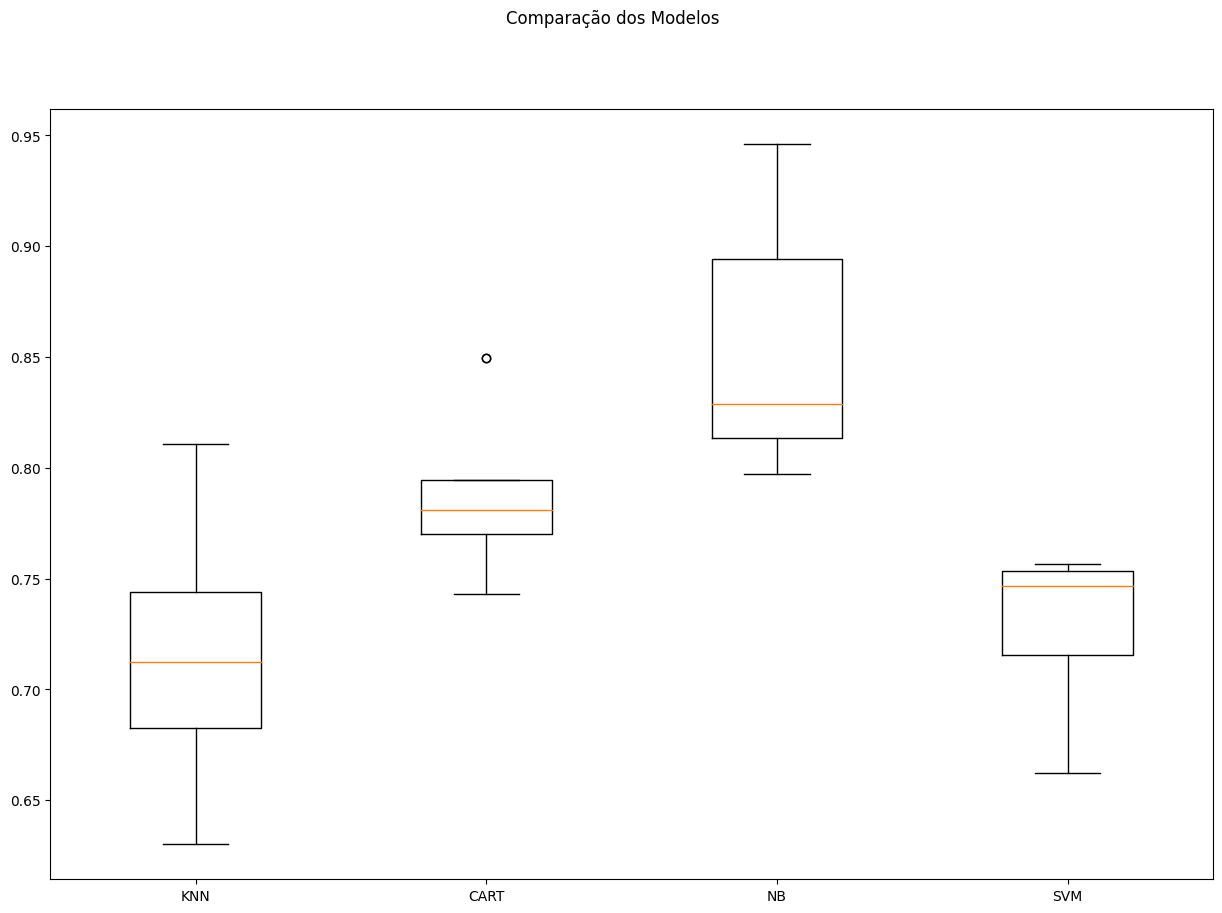

In [ ]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.710 (0.053)
CART-orig: 0.789 (0.034)
NB-orig: 0.853 (0.050)
SVM-orig: 0.729 (0.033)
KNN-padr: 0.857 (0.037)
CART-padr: 0.794 (0.029)
NB-padr: 0.853 (0.050)
SVM-padr: 0.862 (0.037)
KNN-norm: 0.852 (0.041)
CART-norm: 0.801 (0.034)
NB-norm: 0.853 (0.050)
SVM-norm: 0.862 (0.039)


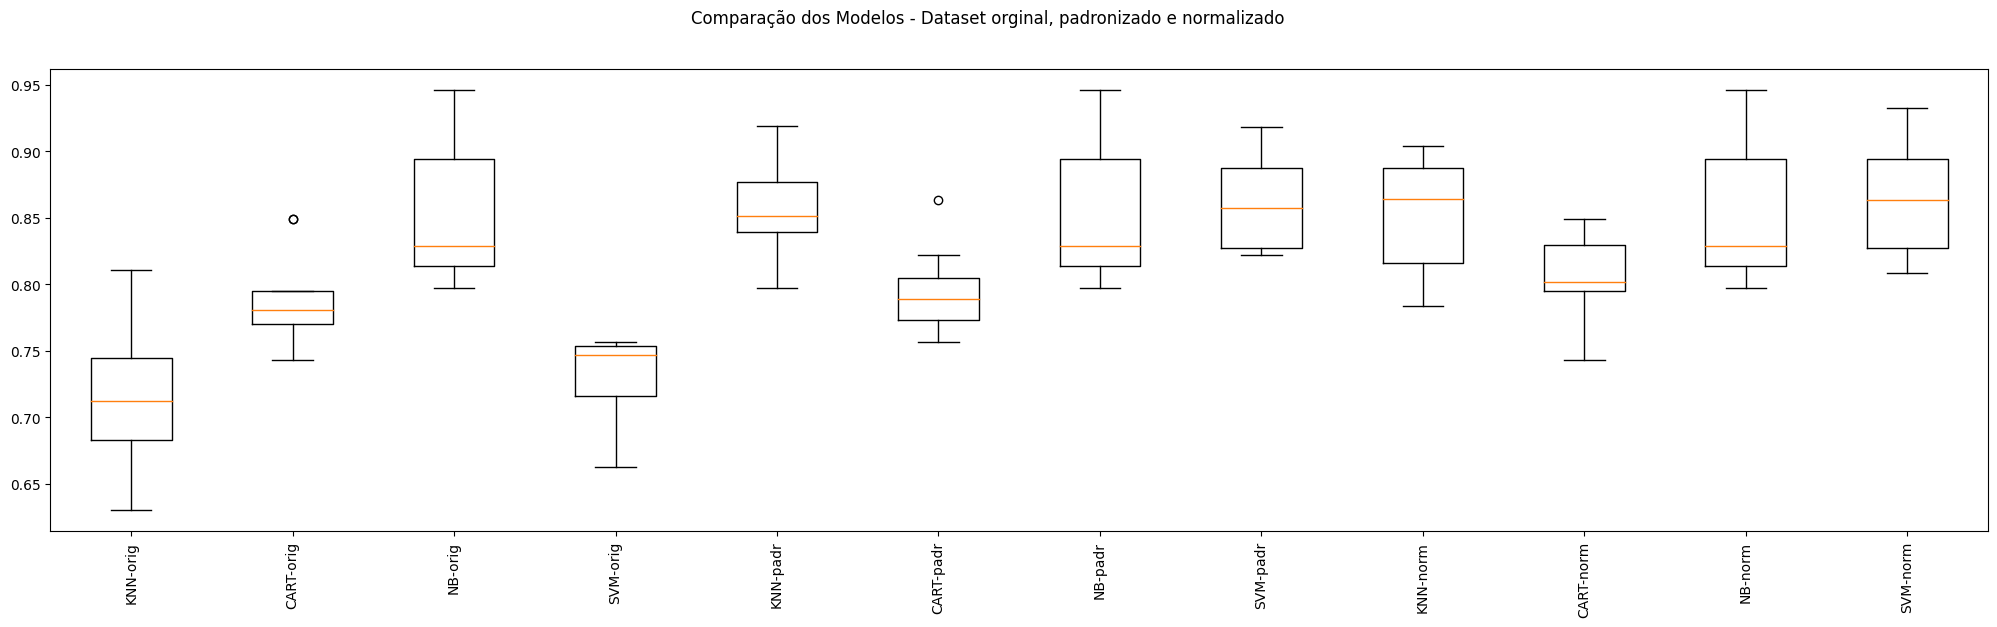

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [ ]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Modelo: knn-orig - Melhor: 0.771214 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}
Modelo: knn-padr - Melhor: 0.867827 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 15}
Modelo: knn-norm - Melhor: 0.866586 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 21}


## Finalização do Modelo

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='manhattan', n_neighbors=13)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.8532608695652174


In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=13)

## Simulando a aplicação do modelo em dados não vistos

In [ ]:
# Novos dados - não sabemos a classe!
data = {
    'age':  [40, 49, 37],
    'sex':  [1, 0, 1],
    'rest': [140, 160, 130],
    'chol': [289, 180, 283],
    'fast': [0, 0, 0],
    'max':  [172, 156, 98],
    'exerc':[0, 0, 0],
    'oldp': [0.0, 1.0, 0.0],
    'st_down': [0, 0, 0],
    'st_flat': [0, 1, 0],
    'st_up':  [1, 0, 1],
    'cp_ASY': [0, 0, 0],
    'cp_ATA': [1, 0, 1],
    'cp_NAP': [0, 1, 0],
    'cp_TA':  [0, 0, 0],
    'rest_LVH':   [0, 0, 0],
    'rest_normal':[1, 1, 0],
    'rest_ST':    [0, 0, 1],
}

atributos = ['age', 'sex', 'rest', 'chol', 'fast', 'max', 'exerc', 'oldp', 'st_down', 'st_flat', 'st_up', 'cp_ASY', 'cp_ATA', 'cp_NAP', 'cp_TA', 'rest_LVH', 'rest_normal', 'rest_ST']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:, 0:18].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-1.45652071  0.50467896  0.42331206  0.82451946 -0.56791066  1.38385638
  -0.8431819  -0.83568186 -0.26452003 -0.98915957  1.1280274  -1.09134998
   2.07818204 -0.5342884  -0.22038927 -0.49616526  0.82439909 -0.51104636]
 [-0.48589872 -1.98145767  1.54887283 -0.17773682 -0.56791066  0.74353451
  -0.8431819   0.08353062 -0.26452003  1.01095923 -0.88650329 -1.09134998
  -0.4811898   1.87164833 -0.22038927 -0.49616526  0.82439909 -0.51104636]
 [-1.78006137  0.50467896 -0.13946833  0.76934939 -0.56791066 -1.57763226
  -0.8431819  -0.83568186 -0.26452003 -0.98915957  1.1280274  -1.09134998
   2.07818204 -0.5342884  -0.22038927 -0.49616526 -1.21300473  1.95676963]]


In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0. 1. 0.]



# Gerar arquivo de modelo treinado

In [ ]:
pickle_out = open("modelo.pkl", "wb");
pickle.dump(model, pickle_out)
pickle_out.close()